# Automatic differentiation with Julia
A modern gospel

For code visit
https://github.com/sintefmath/SimpleAD.jl

# Why Julia?

$$\mathrm{Julia}\in \mathrm{Fast} \cap \mathrm{Scripting}$$

In [1]:
# Solve the ODE y'(t) = F(y(t), t) using FE
function solve_ode(y0, F; T=1.0, dt=1/2^10)
    t = collect(0:dt:T)
    y = zero(t)
    y[1] = y0
    for i in 1:size(t, 1) - 1
         y[i + 1] = y[i] + dt * F(y[i], t[i])
    end
    return t, y
end
t, y = solve_ode(0.5, (y, t) -> y * sin(4pi*t));

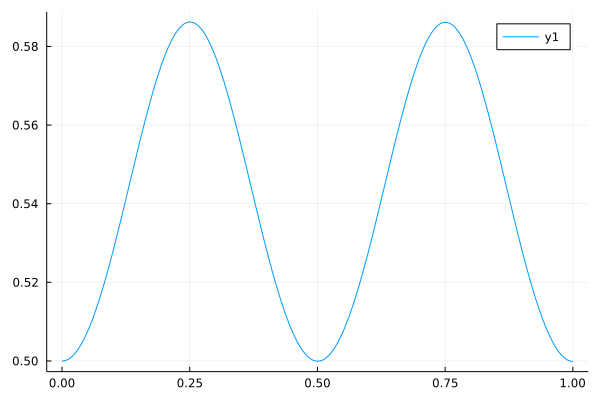

In [2]:
# Forecasting: Notice how long this takes!
using Plots
plot(t, y)

In [3]:
using Zygote
function newton(F, x0)
    DF(x) = gradient(F, x)[1]
    x = x0
    for i in 1:100
        x = x - F(x)/DF(x)
        if F(x) < eps()
            break
        end
    end
    return x
end
F(x) = exp(x^2) - 2.0
@show newton(F, 2.0)
@time newton(F, 2.0);


newton(F, 2.0) = 0.8325546111576978
  0.000001 seconds


# Speed comparison
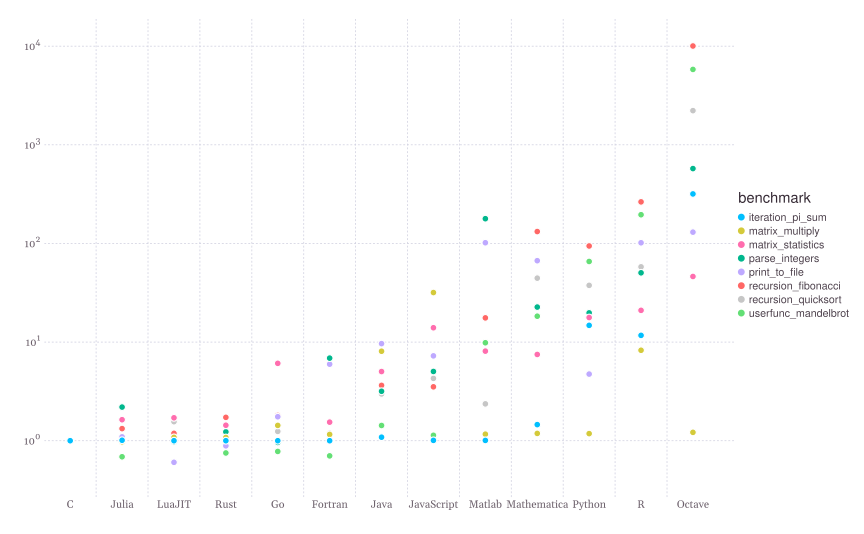

# A crash course in Julia

In [4]:
function my_function(argument, typed_argument::Int; default_argument=10.0)
    # Types
    variable = 42
    @show typeof(variable) # @<name> is a macro
    variable = 42.5
    @show typeof(variable) # @<name> is a macro
    variable_declared_with_type::Float64 = 42
    @show typeof(variable_declared_with_type)
end
my_function("Some string", 123, default_argument="Completely different");

typeof(variable) = Int64
typeof(variable) = Float64
typeof(variable_declared_with_type) = Float64


In [5]:
# Parametric types
vector_of_floats = Vector{Float64}(undef, 3)
@show size(vector_of_floats)
two_dimensional_array = Array{Float64, 2}(undef, 3,3)
@show size(two_dimensional_array);

size(vector_of_floats) = (3,)
size(two_dimensional_array) = (3, 3)


In [6]:
# Functions
function function_name(argument1, argument2; named_argument=42)
    # return value is value of last executed statement
    if argument1 < argument2
        24
    else
        80
    end
end
@show function_name(10, 20)
@show function_name(20, 10);

function_name(10, 20) = 24
function_name(20, 10) = 80


# Am I getting a free lunch?

# Performance issues

Julia specific issues
* Type stability
* Compilation times
* Mutability/memory allocations
* Time to first plot

In addition to the usual suspects

In [7]:
# Type stability
function relu_slow(x)
    if x > 0
        return x
    else
        return 0
    end
end
@code_warntype relu_slow(1.0)

MethodInstance for relu_slow(::Float64)
  from relu_slow(x) in Main at In[7]:2
Arguments
  #self#::Core.Const(relu_slow)
  x::Float64
Body::Union{Float64, Int64}
1 ─ %1 = (x > 0)::Bool
└──      goto #3 if not %1
2 ─      return x
3 ─      return 0



In [8]:
# Type stability
function relu_fast(x)
    if x > 0
        return x
    else
        return zero(x)
    end
end
@code_warntype relu_fast(1.0)

MethodInstance for relu_fast(::Float64)
  from relu_fast(x) in Main at In[8]:2
Arguments
  #self#::Core.Const(relu_fast)
  x::Float64
Body::Float64
1 ─ %1 = (x > 0)::Bool
└──      goto #3 if not %1
2 ─      return x
3 ─ %4 = Main.zero(x)::Core.Const(0.0)
└──      return %4



In [9]:
# Type stability
function relu_typed(x::T)::T where {T <: Real}
    if x > 0
        return x
    else
        return 0
    end
end
@code_warntype relu_typed(1.0)

MethodInstance for relu_typed(::Float64)
  from relu_typed(x::T) where T<:Real in Main at In[9]:2
Static Parameters
  T = Float64
Arguments
  #self#::Core.Const(relu_typed)
  x::Float64
Body::Float64
1 ─ %1 = $(Expr(:static_parameter, 1))::Core.Const(Float64)
│   %2 = (x > 0)::Bool
└──      goto #3 if not %2
2 ─ %4 = Base.convert(%1, x)::Float64
│   %5 = Core.typeassert(%4, %1)::Float64
└──      return %5
3 ─ %7 = Base.convert(%1, 0)::Core.Const(0.0)
│   %8 = Core.typeassert(%7, %1)::Core.Const(0.0)
└──      return %8



In [15]:
@code_llvm relu_typed(1.0)
println("-"^80)
@code_llvm relu_fast(1.0) 

;  @ In[9]:2 within `relu_typed`
define double @julia_relu_typed_6485(double %0) #0 {
top:
;  @ In[9]:3 within `relu_typed`
  %.inv = fcmp ogt double %0, 0.000000e+00
  %1 = select i1 %.inv, double %0, double 0.000000e+00
;  @ In[9]:4 within `relu_typed`
  ret double %1
}
--------------------------------------------------------------------------------
;  @ In[8]:2 within `relu_fast`
define double @julia_relu_fast_6491(double %0) #0 !dbg !5 {
top:
;  @ In[8]:3 within `relu_fast`
  %.inv = fcmp ogt double %0, 0.000000e+00, !dbg !7
  %1 = select i1 %.inv, double %0, double 0.000000e+00, !dbg !7
;  @ In[8]:4 within `relu_fast`
  ret double %1, !dbg !8
}


# For more performance information

See the offical Julia guide at 

https://docs.julialang.org/en/v1/manual/performance-tips/

and the following auxillary documentation

https://enccs.github.io/Julia-for-HPC/

https://book.sciml.ai/notes/02/

See also  the general documentation at

https://docs.julialang.org/en/v1/manual/getting-started/

# How we  use Julia

* Jutul.jl: Multiphysics simulator. Batteries/reservoir
* FastAcoustics.jl: (not done) ECAC/NORTIM  noise  calculation in CUDA
* In progress:  Rumpetroll.jl: Shallow water equations in CUDA
* Planned: Frosk.jl: Terrain models for surface water